### Data Set Information:

This dataset represents a real-life benchmark in the area of Activity Recognition applications, as described in [1].

The classification tasks consist in predicting the activity performed by the user from time-series generated by a Wireless Sensor Network (WSN), according to the EvAAL competition technical annex ([Web Link]).

In our activity recognition system we use information coming the implicit alteration of the wireless channel due to the movements of the user. The devices measure the RSS of the beacon packets they exchange among themselves in the WSN [2].

We collect RSS data using IRIS nodes embedding a Chipcon AT86RF230 radio subsystem that implements the IEEE 802.15.4 standard and programmed with a TinyOS firmware. They are placed on the userâ€™s chest and ankles. For the purpose of communications, the beacon packets are exchanged by using a simple virtual token protocol that completes its execution in a time slot of 50 milliseconds. A modified version of the Spin ([Web Link]) token-passing protocol is used to schedule node transmission, in order to prevent packet collisions and maintain high data collection rate. When an anchor is transmitting, all other anchors receive the packet and perform the RSS measurements. The payload of the transmitting packet is the set of RSS values between the transmitting node and the other sensors sampled during the previous cycle.

From the raw data we extract time-domain features to compress the time series and slightly remove noise and correlations.

We choose an epoch time of 250 milliseconds according to the EVAAL technical annex. In such a time slot we elaborate 5 samples of RSS (sampled at 20 Hz) for each of the three couples of WSN nodes (i.e. Chest-Right Ankle, Chest-Left Ankle, Right Ankle-Left Ankle). The features include the mean value and standard deviation for each reciprocal RSS reading from worn WSN sensors.

For each activity 15 temporal sequences of input RSS data are present. The dataset contains 480 sequences, for a total number of 42240 instances.

We also consider two kind of bending activity, illustrated in the figure provided (bendingTupe.pdf). The positions of sensor nodes with the related identifiers are shown in figure sensorsPlacement.pdf.


#### Attribute Information:

For each sequence, data is provided in comma separated value (csv) format.

- Input data:
Input RSS streams are provided in files named datasetID.csv, where ID is the progressive numeric sequence ID for each repetition of the activity performed.
In each file, each row corresponds to a time step measurement (in temporal order) and contains the following information:
avg_rss12, var_rss12, avg_rss13, var_rss13, avg_rss23, var_rss23
where avg and var are the mean and variance values over 250 ms of data, respectively.

- Target data:
Target data is provided as the containing folder name.




download the dataset from https://archive.ics.uci.edu/ml/machine-learning-databases/00366/AReM.zip

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import os
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [74]:
# a full function for concatinating all files into a single file 

def files(path):
    folders = [i for i in os.listdir(path) if not i.endswith('.pdf')]
    dir_path = [path + f'\{i}' for i in folders ] 
    list_of_files_in_dir =[ os.listdir(folder) for folder in dir_path ] 
    
    main_df = pd.DataFrame()
    column_names = [ 'time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
    for i in range(len(dir_path)):
        for j in range(len(list_of_files_in_dir[i])):
            file_path = f'{dir_path[i]}\{list_of_files_in_dir[i][j]}'
            df =  pd.read_csv(file_path, skiprows=5, names=column_names ,error_bad_lines=False)
            df['label']= folders[i]
            
            na_count = 0
            
            """reference of the below operation is stated below """
            
            for column in range(1, len(column_names)):
                na_count+= df[column_names[column]].isna().sum()
            if len(df)*6 != na_count:
                
                main_df = pd.concat([main_df,df])
                
            else:
                df1 = pd.read_csv(file_path, skiprows=5, names=column_names , sep = ' ', index_col= False, error_bad_lines=False)
                df1['label']= folders[i]
                main_df = pd.concat([main_df, df1])
                
    return main_df
    
    

 some dataset had seperator as ' '(space), iterating through the datasets with default seperators 
 could cause issue, so separated that specific dataset by setting the seperator as space (''). First of all I tried to seperate each dataset with the default comma seperators, but whichever dataset will have the space as seperator, that will store every data into its first column itself and the rest will be NA, so I checked if the total NA values of the dataset is equal to the number of coulumns (exluding the first column) multiplied by the length of the dataset. If it's true, then it was just because the dataset has space as seperator.
 
 
 
 

In [75]:
path = "E:\\ML\\LOGISTIC REGRESSION PRACTICE\\task11.09\\AReM"
all_csv = files(path)

<ipython-input-75-05e822ce31ec>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  all_csv = files(path)


In [4]:
all_csv.drop(columns= 'time', inplace=  True)

In [5]:
all_csv

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,label
0,39.25,0.43,22.75,0.43,33.75,1.30,bending1
1,39.25,0.43,23.00,0.00,33.00,0.00,bending1
2,39.25,0.43,23.25,0.43,33.00,0.00,bending1
3,39.50,0.50,23.00,0.71,33.00,0.00,bending1
4,39.50,0.50,24.00,0.00,33.00,0.00,bending1
...,...,...,...,...,...,...,...
475,31.50,1.66,12.50,3.20,14.25,4.44,walking
476,27.33,1.25,11.33,0.94,20.00,4.00,walking
477,37.80,7.68,14.20,2.48,17.25,0.83,walking
478,33.75,1.30,15.75,5.21,16.50,2.69,walking


<AxesSubplot:>

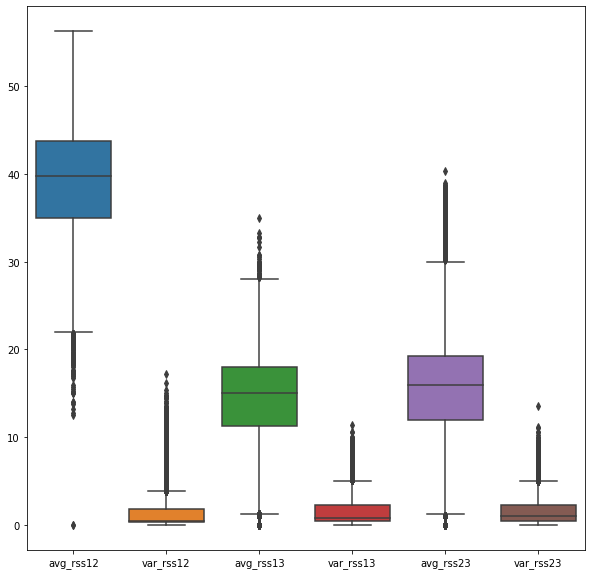

In [6]:
fig, ax = plt.subplots(figsize =( 10,10))
sns.boxplot( data = all_csv)

## removing outliers

In [7]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [8]:
df_new1 = remove_outlier(all_csv,'avg_rss12')

In [9]:
q = df_new1['var_rss12'].quantile(.98)
df_new1 = df_new1[df_new1['var_rss12'] < q]

q = df_new1['avg_rss13'].quantile(.98)
df_new1 = df_new1[df_new1['avg_rss13'] < q]

q = df_new1['var_rss13'].quantile(.98)
df_new1 = df_new1[df_new1['var_rss13'] < q]

q = df_new1['var_rss23'].quantile(.98)
df_new1 = df_new1[df_new1['var_rss23'] < q]

q = df_new1['avg_rss23'].quantile(.98)
df_new1 = df_new1[df_new1['avg_rss23'] < q]

In [10]:
df_new1

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,label
1,39.25,0.43,23.00,0.00,33.00,0.00,bending1
2,39.25,0.43,23.25,0.43,33.00,0.00,bending1
3,39.50,0.50,23.00,0.71,33.00,0.00,bending1
7,39.00,0.00,23.75,0.43,33.00,0.00,bending1
9,39.50,0.50,23.00,0.00,33.00,0.00,bending1
...,...,...,...,...,...,...,...
474,37.25,7.26,14.00,1.58,13.25,4.92,walking
475,31.50,1.66,12.50,3.20,14.25,4.44,walking
476,27.33,1.25,11.33,0.94,20.00,4.00,walking
478,33.75,1.30,15.75,5.21,16.50,2.69,walking


<AxesSubplot:>

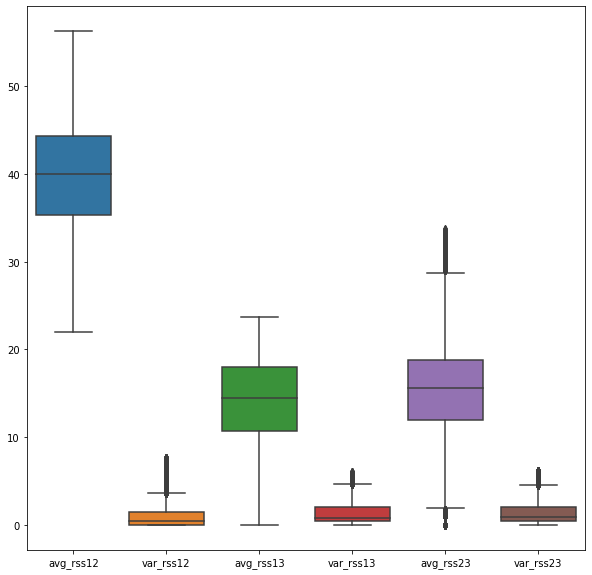

In [76]:
fig, ax = plt.subplots(figsize =( 10,10))
sns.boxplot( data =df_new1 )

In [11]:
def vif(df):

    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                              for i in range(len(df.columns))]
    return vif_data

In [80]:
features = df_new1.drop(columns= 'label')
vif(features)

,feature,VIF
0,avg_rss12,8.709957
1,var_rss12,2.846642
2,avg_rss13,9.856633
3,var_rss13,3.411978
4,avg_rss23,9.009724
5,var_rss23,3.777867


## scaling the feature dataset

In [49]:
scaler = StandardScaler()
x_scl1 = pd.DataFrame(scaler.fit_transform(df_new1[['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23',
                                                        'var_rss23']]), columns=['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23','var_rss23'])

In [81]:
vif(x_scl1)

,feature,VIF
0,avg_rss12,1.178992
1,var_rss12,1.889205
2,avg_rss13,1.277291
3,var_rss13,1.802036
4,avg_rss23,1.244205
5,var_rss23,1.826350


# Building model 

In [14]:
all_csv.label = all_csv.label.astype('category')
all_csv.label = all_csv.label.cat.codes

In [15]:
x = x_scl1
y = df_new1[['label']]

In [83]:
x.shape

(37531, 6)

In [84]:
y.shape

(37531, 1)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=144)

# LOGISTIC REGRESSION USING MULTIPLE SOLVERS 

## 'lbfgs'

In [19]:
OUT_logr_lbfgs = LogisticRegression(solver= 'lbfgs', multi_class= 'ovr')

In [20]:
OUT_logr_lbfgs.fit(x_train, y_train)

C:\Users\neogi\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(multi_class='ovr')

In [21]:
_out_y_lbfgs_pred = OUT_logr_lbfgs.predict(x_test)

In [22]:
Accuracy_lbfgs = accuracy_score(y_test, _out_y_lbfgs_pred)
Accuracy_lbfgs

0.6432662848008526

In [23]:
confusion_matrix(y_test, _out_y_lbfgs_pred).ravel()

array([ 242,    2,    9,    0,  101,   20,    0,   14,  336,   13,   68,
         41,    4,    9,    8,    6,  666,    7,   59,   24,  371,    0,
         28,    3, 1296,    4,  109,    5,   38,   78,   56,  230,  523,
        499,    3,    4,    0,   24,  201,  263,  954,    2,    0,   13,
        346,    2,    3,   11,  812], dtype=int64)

In [24]:
pd.DataFrame(classification_report(y_test, _out_y_lbfgs_pred, target_names=['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking'], output_dict=True))

,bending1,bending2,cycling,lying,sitting,standing,walking,accuracy,macro avg,weighted avg
precision,0.790850,0.725702,0.596240,0.718404,0.526157,0.588526,0.675541,0.643266,0.660203,0.635543
recall,0.647059,0.692784,0.583699,0.896886,0.366503,0.658840,0.684078,0.643266,0.647121,0.643266
f1-score,0.711765,0.708861,0.589903,0.797784,0.432053,0.621701,0.679782,0.643266,0.648835,0.634013
support,374.000000,485.000000,1141.000000,1445.000000,1427.000000,1448.000000,1187.000000,0.643266,7507.000000,7507.000000


## solver = 'liblinear'

In [25]:
_out_lbl_logr = LogisticRegression(solver='liblinear', multi_class= 'ovr')
_out_lbl_logr.fit(x_train, y_train)
_out_y_pred_liblr = _out_lbl_logr.predict(x_test)

C:\Users\neogi\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [26]:
Accuracy_liblinear = accuracy_score(y_test, _out_y_pred_liblr)
Accuracy_liblinear

0.6433994938057813

In [27]:
pd.DataFrame(classification_report(y_test, _out_y_pred_liblr, target_names=['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking'], output_dict=True))

,bending1,bending2,cycling,lying,sitting,standing,walking,accuracy,macro avg,weighted avg
precision,0.790850,0.725702,0.596774,0.718006,0.526157,0.588889,0.675810,0.643399,0.660313,0.635661
recall,0.647059,0.692784,0.583699,0.896886,0.366503,0.658840,0.684920,0.643399,0.647241,0.643399
f1-score,0.711765,0.708861,0.590164,0.797538,0.432053,0.621904,0.680335,0.643399,0.648946,0.634132
support,374.000000,485.000000,1141.000000,1445.000000,1427.000000,1448.000000,1187.000000,0.643399,7507.000000,7507.000000


## solver = 'sag'

In [28]:
out_sag_logr = LogisticRegression(solver='sag', multi_class= 'ovr')
out_sag_logr.fit(x_train, y_train)
out_y_pred_sag = out_sag_logr.predict(x_test)

C:\Users\neogi\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [29]:
Accuracy_sag = accuracy_score(y_test, out_y_pred_sag)
Accuracy_sag

0.6432662848008526

In [30]:
pd.DataFrame(classification_report(y_test, out_y_pred_sag, target_names=['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking'], output_dict=True))

,bending1,bending2,cycling,lying,sitting,standing,walking,accuracy,macro avg,weighted avg
precision,0.790850,0.725702,0.596240,0.718404,0.526157,0.588526,0.675541,0.643266,0.660203,0.635543
recall,0.647059,0.692784,0.583699,0.896886,0.366503,0.658840,0.684078,0.643266,0.647121,0.643266
f1-score,0.711765,0.708861,0.589903,0.797784,0.432053,0.621701,0.679782,0.643266,0.648835,0.634013
support,374.000000,485.000000,1141.000000,1445.000000,1427.000000,1448.000000,1187.000000,0.643266,7507.000000,7507.000000


## solver = 'saga'

In [31]:
out_saga_logr = LogisticRegression(solver='saga', multi_class= 'ovr')
out_saga_logr.fit(x_train, y_train)
out_y_pred_saga = out_saga_logr.predict(x_test)

C:\Users\neogi\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [32]:
Accuracy_saga = accuracy_score(y_test, out_y_pred_saga)
Accuracy_saga

0.6432662848008526

In [33]:
pd.DataFrame(classification_report(y_test, out_y_pred_saga, target_names=['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking'], output_dict=True))

,bending1,bending2,cycling,lying,sitting,standing,walking,accuracy,macro avg,weighted avg
precision,0.790850,0.725702,0.596240,0.718404,0.526157,0.588526,0.675541,0.643266,0.660203,0.635543
recall,0.647059,0.692784,0.583699,0.896886,0.366503,0.658840,0.684078,0.643266,0.647121,0.643266
f1-score,0.711765,0.708861,0.589903,0.797784,0.432053,0.621701,0.679782,0.643266,0.648835,0.634013
support,374.000000,485.000000,1141.000000,1445.000000,1427.000000,1448.000000,1187.000000,0.643266,7507.000000,7507.000000


## solver = 'newton-cg'

In [34]:
out_newtoncg_logr = LogisticRegression(solver='newton-cg', multi_class= 'ovr')
out_newtoncg_logr.fit(x_train, y_train)
out_y_pred_newtoncg = out_newtoncg_logr.predict(x_test)

C:\Users\neogi\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [35]:
Accuracy_newtoncg = accuracy_score(y_test, out_y_pred_newtoncg)
Accuracy_newtoncg

0.6432662848008526

In [36]:
pd.DataFrame(classification_report(y_test, out_y_pred_newtoncg, target_names=['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking'], output_dict=True))

,bending1,bending2,cycling,lying,sitting,standing,walking,accuracy,macro avg,weighted avg
precision,0.790850,0.725702,0.596240,0.718404,0.526157,0.588526,0.675541,0.643266,0.660203,0.635543
recall,0.647059,0.692784,0.583699,0.896886,0.366503,0.658840,0.684078,0.643266,0.647121,0.643266
f1-score,0.711765,0.708861,0.589903,0.797784,0.432053,0.621701,0.679782,0.643266,0.648835,0.634013
support,374.000000,485.000000,1141.000000,1445.000000,1427.000000,1448.000000,1187.000000,0.643266,7507.000000,7507.000000


### which solver should be used to solve this use case?

In [37]:
solvers = {'lbfgs':Accuracy_lbfgs, 'liblinear':Accuracy_liblinear, 'newtoncg':Accuracy_newtoncg, 'sag':Accuracy_sag, 'saga':Accuracy_saga}

In [73]:
for i in solvers.keys():
    maxx = max(solvers.values())
    if solvers[i] == maxx:
        print(f'the "{i}" solver should be used. It has the highest value : {" %.4f" % maxx}')
    

the "liblinear" solver should be used. It has the highest value :  0.6434


## final model

In [39]:
model = LogisticRegression(solver='liblinear', multi_class='ovr')
model.fit(x_train, y_train)

C:\Users\neogi\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(multi_class='ovr', solver='liblinear')

In [52]:
def model_predict(data):
    
    """parameters:
                data = lst
                pass the lists of the values to the columns in the respective order - 
                ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23',
                                                        'var_rss23']
                
            
    """
    scaled_Data = scaler.transform([data])
    predicted_data =  model.predict(scaled_Data)
    return 'the output is {}'.format(''.join([i for i in predicted_data]))
        

In [53]:
model_predict([39.25,0.43,22.75,0.43,33.75,1.3])

'the output is bending1'

In [54]:
model_predict([45.0,0.0,14.75,0.43,19.75,0.83])

'the output is sitting'

In [55]:
model_predict([32.67,3.09,18.67,0.47,14.0,3.16])

'the output is walking'

In [56]:
model_predict([45.0,0.0,21.0,0.0,12.25,0.43])

'the output is standing'

In [57]:
model_predict([45.0,0.0,4.5,0.5,15.67,0.94])

'the output is lying'

In [63]:
data = [28.5,0.5,8.5,0.5,18.25,0.43]
model_predict(data)

'the output is bending2'